<h3>Import all the necessary packages</h3>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


<h3>Load data</h3>

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
#subm = pd.read_csv('../input/sample_submission.csv')

In [6]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h3>Split data into train and validation set</h3>

In [7]:
X_train , X_test , y_train , y_test = train_test_split(train.iloc[: , 1:].values , train.iloc[:,0].values , test_size = 0.1) 

<h3>Inspect one sample</h3>

Text(0.5, 1.0, '28x28 data')

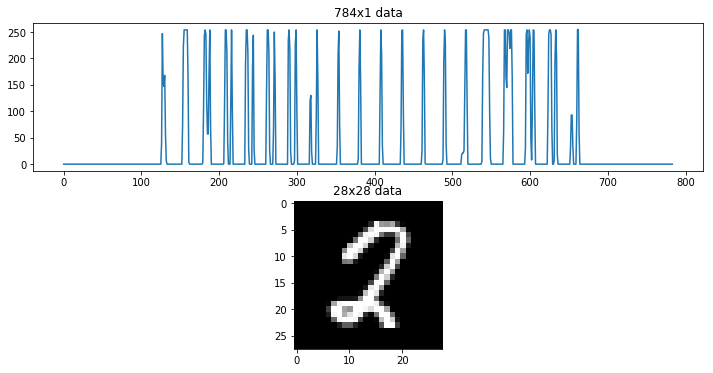

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(12,6))
ax[0].plot(X_train[0])
ax[0].set_title('784x1 data')
ax[1].imshow(X_train[0].reshape(28,28), cmap='gray')
ax[1].set_title('28x28 data')

<h3> Resize the flattened images into 28x28x1 pixels images and regularize it by dividing it with highest value ie 255</h3>

In [9]:
X_train = X_train.reshape(-1 , 28 , 28 , 1)/255
X_test = X_test.reshape(-1 , 28 , 28 , 1)/255

### OneHot encoding

In [10]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [11]:
print(y_train[0])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


### Creating Keras model 

In [12]:
model = Sequential()
model.add(Conv2D(filters = 16 , kernel_size= (3,3) , activation= 'relu' , input_shape = (28 , 28 ,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters= 16 , kernel_size= (3,3) , activation= 'relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters= 16 , kernel_size= (3,3) , activation= 'relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Data Augmentation to increate training size

In [13]:
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

In [14]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])

In [15]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [34]:
hist = model.fit_generator(datagen.flow(X_train , y_train , batch_size=16) ,
                          steps_per_epoch = 500 ,
                           epochs = 20, #20
                           verbose =2,
                           callbacks=[annealer]
                          )

Epoch 1/20
 - 37s - loss: 0.3060 - acc: 0.9078
Epoch 2/20
 - 36s - loss: 0.2487 - acc: 0.9224
Epoch 3/20
 - 36s - loss: 0.2128 - acc: 0.9400
Epoch 4/20
 - 36s - loss: 0.1934 - acc: 0.9455
Epoch 5/20
 - 36s - loss: 0.1676 - acc: 0.9497
Epoch 6/20
 - 36s - loss: 0.1505 - acc: 0.9561
Epoch 7/20
 - 36s - loss: 0.1563 - acc: 0.9539
Epoch 8/20
 - 36s - loss: 0.1363 - acc: 0.9590
Epoch 9/20
 - 36s - loss: 0.1403 - acc: 0.9570
Epoch 10/20
 - 36s - loss: 0.1252 - acc: 0.9614
Epoch 11/20
 - 36s - loss: 0.1219 - acc: 0.9656
Epoch 12/20
 - 36s - loss: 0.1105 - acc: 0.9677
Epoch 13/20
 - 36s - loss: 0.0919 - acc: 0.9714
Epoch 14/20
 - 36s - loss: 0.1062 - acc: 0.9681
Epoch 15/20
 - 36s - loss: 0.0903 - acc: 0.9751
Epoch 16/20
 - 36s - loss: 0.1044 - acc: 0.9711
Epoch 17/20
 - 36s - loss: 0.0911 - acc: 0.9733
Epoch 18/20
 - 36s - loss: 0.0852 - acc: 0.9709
Epoch 19/20
 - 36s - loss: 0.0890 - acc: 0.9725
Epoch 20/20
 - 36s - loss: 0.0887 - acc: 0.9742


In [35]:
final_loss, final_acc = model.evaluate(X_test, y_test, verbose=0)
print('loss =' , final_loss , '\naccuracy' , final_acc)

loss = 0.027488322670216718 
accuracy 0.9921428571428571


<h4>Submit</h4>

In [37]:
test = pd.read_csv('test.csv')
test = test.values
test = test.reshape(-1 , 28 , 28 ,1)/255
#pre = model.predict(test, batch_size=64)

# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [38]:
#pre = np.argmax(pre , axis = 1)

In [39]:
#pre

In [40]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("submission.csv",index=False)